Вычислить изоформы, экспрессия которых сильно отличается при разных трансдукциях. В качестве примера, рассмотрим *exclusive* изоформы.

- Для каждой трансдукции понять, что означает значимо экспрессированая изоформа (гистограммы)
- Значимое изменение можно отловить построив scatterplot ззначимых изоформ для двух видов трансдукции (RPM: NaN =? 0)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps

In [3]:
def path(name, type_):
    return "~ksuma/isomirs/" + name + "_isomir/output-IsoMiRmap_v5-"+type_+"-isomiRs.expression.txt"

In [4]:
def get_table(name, type_, dig):
    ''' Reading the file '''
    df = pd.read_fwf(path(name, type_), delimiter = '/t')
    df = df['## Table of '+type_+'-isomiRs.'].str.split('\t', expand = True)
    df.columns = df.loc[dig]
    
    ''' Deleting tandem repeats (in case of exclusive it is not neccessary)'''
    df = df.where(df[df.columns[-1]] == '').dropna()
    df = df.rename(columns = {df.columns[-1] :'Repeated'})
    df = df.rename(columns = {'Mature meta-data (bracket delimited per hairpin)' :'Mature'})
    
    df.index = 1 + np.arange(0, len(df))
    df['RPM '+name] = pd.to_numeric(df['RPM**'])
    return df[['License Plate', 'IsomiR sequence', 'RPM ' + name, 
               'Mature']]

def get_type(name, table, typ):
    table[name+' type'] = [typ if table['RPM '+name].loc[i] else 0 for i in range(table.shape[0])]
    return table

In [5]:
ELOV5 = get_table("ELOV5", "exclusive", 5)
IGFBP6 = get_table("IGFBP6", "exclusive", 5)
LUC = get_table("LUC", "exclusive", 5)

In [6]:
ELOV5_excl = ELOV5.drop('Mature', axis = 1)
IGFBP6_excl = IGFBP6.drop('Mature', axis = 1)
LUC_excl = LUC.drop('Mature', axis = 1)
exclusive = pd.concat([ELOV5_excl, IGFBP6_excl, LUC_excl])   # concat all factors in the one table
exclusive = exclusive.groupby('License Plate').agg({'IsomiR sequence' : 'first', 'RPM ELOV5':'first',
                             'RPM IGFBP6': 'first', 'RPM LUC':'first' }).reset_index()

exclusive.replace(np.nan, 0, inplace=True)   # change NaN RPM values to zero
# # exclusive.dropna()

In [7]:
def filter_data(df, column):
    q_low = df[column].quantile(0.01)
    q_hi  = df[column].quantile(0.99)

    df_filtered = df[(df[column] < q_hi) & (df[column] > q_low)]
    return df_filtered

In [8]:
exclusive_filtered = filter_data(exclusive, 'RPM IGFBP6')
exclusive_filtered = filter_data(exclusive, 'RPM LUC')
exclusive_filtered = filter_data(exclusive, 'RPM ELOV5')

#### Histograms

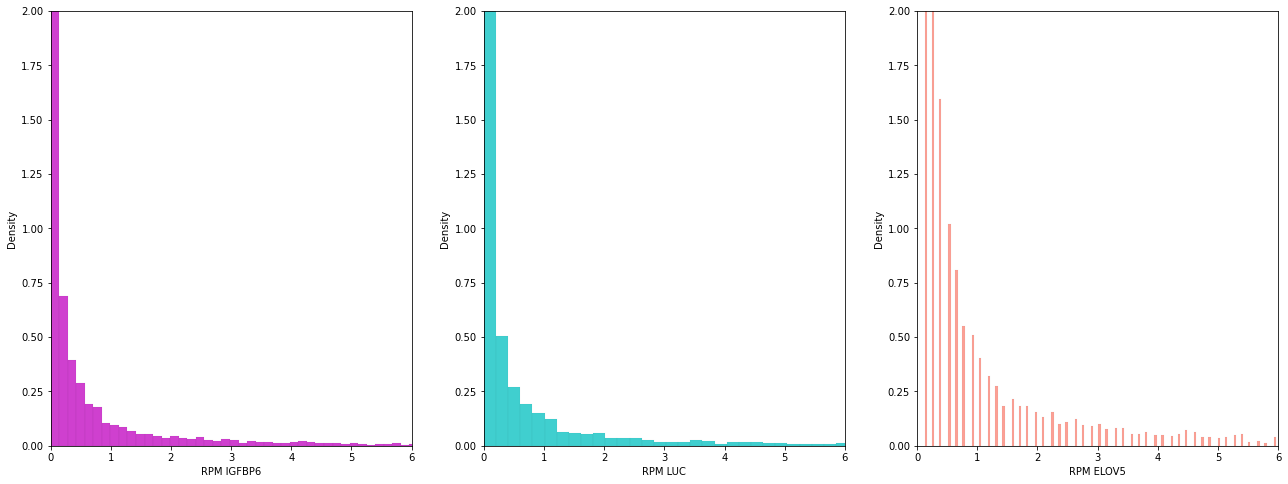

In [9]:
fig, axs = plt.subplots(1, 3, figsize = (22, 8))
for ind, name in enumerate([["RPM IGFBP6", 'm', 1000],
                            ["RPM LUC", 'c', 1500],
                            ["RPM ELOV5", 'salmon', 1500]]):
    
    sns.histplot(data=exclusive_filtered, x=name[0], 
                 stat = 'density', bins = name[2], color = name[1], ax = axs[ind])
    axs[ind].set_ylim([0, 2])
    axs[ind].set_xlim([0, 6])

plt.show()

#### Scatter plots

In [10]:
def cond(name):
    return exclusive['RPM '+name] > 1000
diff_excl = exclusive[(cond('ELOV5')) | (cond('LUC')) | (cond('IGFBP6'))]

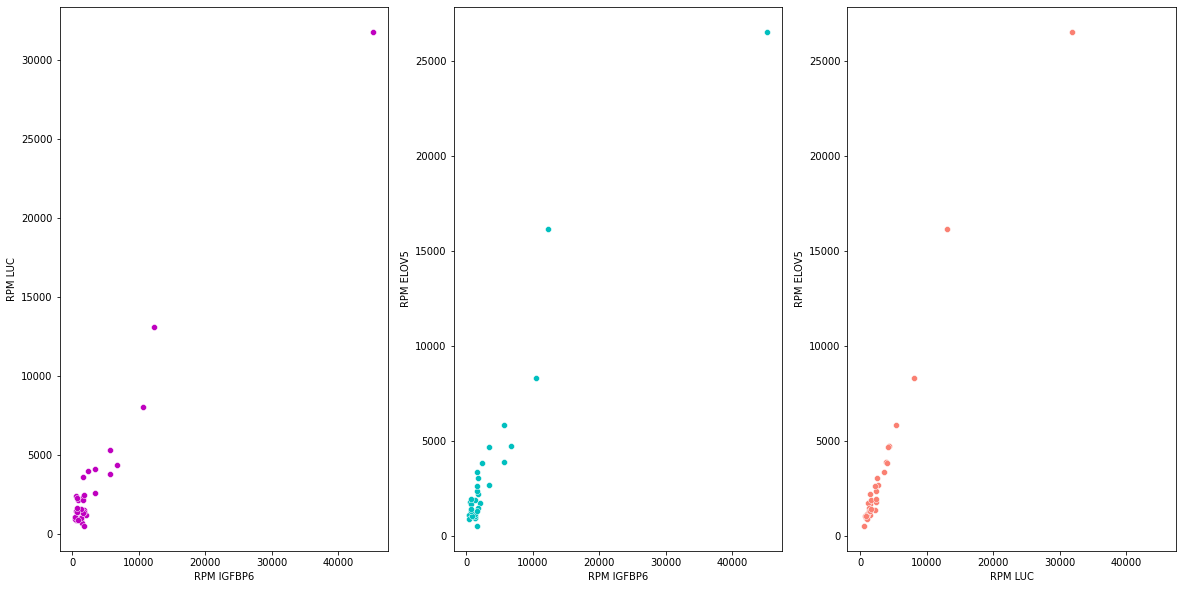

In [11]:
%matplotlib inline
fig, axs = plt.subplots(1, 3, sharey = False, sharex = True, figsize = (20, 10))
sns.scatterplot(data=diff_excl, x="RPM IGFBP6", y="RPM LUC", color = 'm', ax = axs[0])
sns.scatterplot(data=diff_excl, x="RPM IGFBP6", y="RPM ELOV5", color = 'c', ax = axs[1])
sns.scatterplot(data=diff_excl, x="RPM LUC", y="RPM ELOV5", color = 'salmon', ax = axs[2])
plt.show()

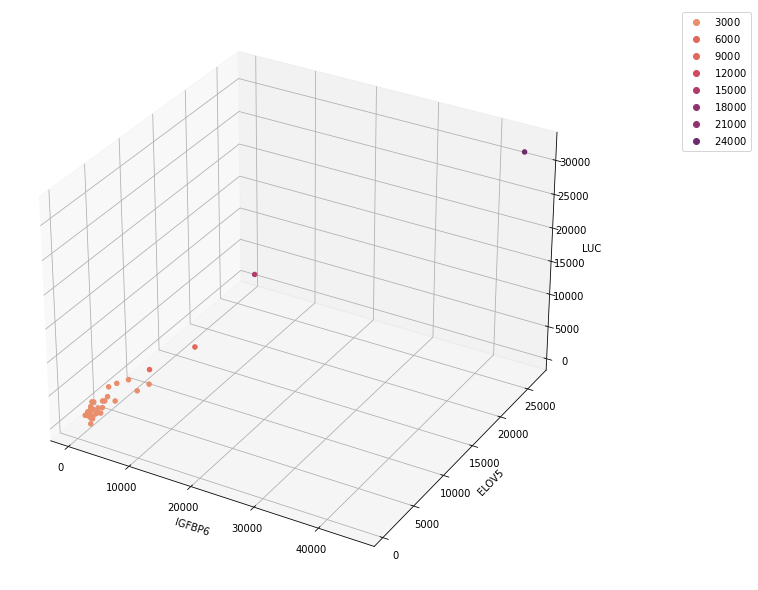

In [12]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# axes instance
fig = plt.figure(figsize=(8 ,10))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("flare").as_hex())

# plot
x = diff_excl["RPM IGFBP6"]
y = diff_excl["RPM ELOV5"]
z = diff_excl["RPM LUC"]

sc = ax.scatter(x, y, z, c=y, cmap=cmap, alpha=1)
ax.set_xlabel('IGFBP6')
ax.set_ylabel('ELOV5')
ax.set_zlabel('LUC')
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.3, 1))
plt.show()

#### finding genes with the most difference in the expression

In [13]:
def cond(name):
    return exclusive['RPM '+name] > 500

def diff(name1, name2):
    return np.log2(1 + exclusive['RPM '+name1]) - np.log2(1 + exclusive['RPM '+name2])

diff_excl = exclusive[(cond('ELOV5')) | (cond('LUC')) | (cond('IGFBP6'))]

diff_excl.insert(diff_excl.shape[1], "ELOV5_LUC", diff('ELOV5', 'LUC'), True)
diff_excl.insert(diff_excl.shape[1], "IGFBP6_LUC", diff('IGFBP6', 'LUC'), True)
diff_excl.insert(diff_excl.shape[1], "ELOV5_IGFBP6", diff('ELOV5', 'IGFBP6'), True)

m = diff_excl[(abs(diff_excl['ELOV5_LUC']) >= 1.5) | 
          (abs(diff_excl['IGFBP6_LUC']) >= 1.5) |
         (abs(diff_excl['ELOV5_IGFBP6']) >= 1.5)]
m

5,License Plate,IsomiR sequence,RPM ELOV5,RPM IGFBP6,RPM LUC,ELOV5_LUC,IGFBP6_LUC,ELOV5_IGFBP6
8308,iso-21-Y51840YYD,TTCACAGTGGCTAAGTTCTGC,1818.68,479.17,2389.28,-0.393495,-2.315562,1.922068
8309,iso-21-Y51840YYE,TTCACAGTGGCTAAGTTCTGT,405.97,100.73,542.83,-0.418233,-2.418411,2.000177
10435,iso-22-9IJNJF6DH,TGGCTCAGTTCAGCAGGAACAG,1133.99,507.99,1465.79,-0.369983,-1.526953,1.156970
10970,iso-22-DIPPZBOIN,AAGCTGCCAGTTGAAGAACTGT,1135.84,360.95,944.47,0.265926,-1.385241,1.651167
13813,iso-22-XKVL7YXYP,TGAGGTAGTAGTTTGTGCTGTG,120.66,142.55,510.05,-2.070610,-1.831911,-0.238698
13822,iso-22-XKVLRY98Q,TGAGGTAGTAGGTTGTGTGGTT,542.56,216.83,638.47,-0.234437,-1.553674,1.319237
14088,iso-22-YOSEKKHKK,TTCAAGTAATCCAGGATAGGCG,118.02,63.50,551.99,-2.216049,-3.099882,0.883833
15565,iso-23-875D3ZB700,TCCCTGAGACCCTTTAACCTGTG,916.91,319.23,1079.80,-0.235675,-1.754919,1.519244
16276,iso-23-BQ8DQWM4Z,AACATTCAACGCTGTCGGTGAGT,703.53,196.35,610.05,0.205371,-1.630534,1.835905
20202,iso-24-9BOX7EZWKE,TGGAAGACTAGTGATTTTGTTGTT,527.81,1659.27,504.98,0.063669,1.714266,-1.650597


In [14]:
exclusive.iloc[8308]

5
License Plate           iso-21-Y51840YYD
IsomiR sequence    TTCACAGTGGCTAAGTTCTGC
RPM ELOV5                        1818.68
RPM IGFBP6                        479.17
RPM LUC                          2389.28
Name: 8308, dtype: object

In [15]:
matrix = []
n = 0
for i in m['License Plate']:
    matrix.append(ELOV5[ELOV5['License Plate'] == i]['Mature'].values[0])
    n +=1
m['Mature'] = matrix
m.to_csv('differ_expression', sep = '\t')

<ipython-input-15-0c11059ea9b4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m['Mature'] = matrix


In [16]:
ELOV5 = get_table("ELOV5", "exclusive", 5)
IGFBP6 = get_table("IGFBP6", "exclusive", 5)
LUC = get_table("LUC", "exclusive", 5)

In [17]:
IGFBP6_expr = IGFBP6[IGFBP6['RPM IGFBP6'] > 500]
ELOV5_expr = ELOV5[ELOV5['RPM ELOV5'] > 500]
LUC_expr = LUC[LUC['RPM LUC'] > 500]
expr = pd.concat([IGFBP6_expr.describe(), ELOV5_expr.describe(), LUC_expr.describe()],axis = 1)
expr

5,RPM IGFBP6,RPM ELOV5,RPM LUC
count,45.000000,56.000000,58.000000
mean,2924.406889,2360.105536,2260.444655
std,6916.542977,4105.795767,4463.230114
min,500.670000,527.810000,504.980000
25%,648.940000,707.182500,635.935000
50%,1247.680000,1111.470000,976.075000
75%,1708.470000,2011.227500,2143.990000
max,45233.220000,26558.390000,31800.670000


**Максимум экспрессии при каждом виде трасндукции отражает одну и ту же изоформу. Более того, у IGFBP2 экспрессия данной изоформы наибольшая, что значительно изменяет значение среднего, поэтому для сранения экспрессии всех инетресуемых изоформ лучше исп-ть медиану**

In [18]:
IGFBP6_expr.sort_values(by = 'RPM IGFBP6', ascending=False).head(5)

5,License Plate,IsomiR sequence,RPM IGFBP6,Mature
1,iso-22-BRS28UEYP,AACCCGTAGATCCGAACTTGTG,45233.22,"[MIMAT0000098&hsa-miR-100-5p&offsets|0|0, m-27..."
2,iso-23-VIV6OYINDR,TAGCTTATCAGACTGATGTTGAC,12214.16,"[MIMAT0000076&hsa-miR-21-5p&offsets|0|+1, m-1&..."
3,iso-22-XKVL7YXYQ,TGAGGTAGTAGTTTGTGCTGTT,10543.66,"[MIMAT0000415&hsa-let-7i-5p&offsets|0|0, m-49&..."
4,iso-21-BRS28UEYE,AACCCGTAGATCCGAACTTGT,6761.78,"[MIMAT0000098&hsa-miR-100-5p&offsets|0|-1, m-2..."
5,iso-22-BRS28UEYO,AACCCGTAGATCCGAACTTGTA,5719.47,[MIMAT0000098&hsa-miR-100-5p&offsets|0|-1(+1A)...


In [19]:
ELOV5_expr.sort_values(by = 'RPM ELOV5', ascending=False).head(6)

5,License Plate,IsomiR sequence,RPM ELOV5,Mature
1,iso-22-BRS28UEYP,AACCCGTAGATCCGAACTTGTG,26558.39,"[MIMAT0000098&hsa-miR-100-5p&offsets|0|0, m-27..."
2,iso-23-VIV6OYINDR,TAGCTTATCAGACTGATGTTGAC,16194.79,"[MIMAT0000076&hsa-miR-21-5p&offsets|0|+1, m-1&..."
3,iso-22-XKVL7YXYQ,TGAGGTAGTAGTTTGTGCTGTT,8314.01,"[MIMAT0000415&hsa-let-7i-5p&offsets|0|0, m-49&..."
4,iso-22-XKVLRYVPQ,TGAGGTAGTAGGTTGTATAGTT,5858.85,"[MIMAT0000062&hsa-let-7a-5p&offsets|0|0, m-6&1..."
5,iso-21-BRS28UEYE,AACCCGTAGATCCGAACTTGT,4748.83,"[MIMAT0000098&hsa-miR-100-5p&offsets|0|-1, m-2..."
6,iso-22-XKVL5YVPQ,TGAGGTAGTAGATTGTATAGTT,4674.41,"[MIMAT0000067&hsa-let-7f-5p&offsets|0|0, m-20&..."


In [21]:
LUC_expr.sort_values(by = 'RPM LUC', ascending=False).head(6)

5,License Plate,IsomiR sequence,RPM LUC,Mature
1,iso-22-BRS28UEYP,AACCCGTAGATCCGAACTTGTG,31800.67,"[MIMAT0000098&hsa-miR-100-5p&offsets|0|0, m-27..."
2,iso-23-VIV6OYINDR,TAGCTTATCAGACTGATGTTGAC,13107.53,"[MIMAT0000076&hsa-miR-21-5p&offsets|0|+1, m-1&..."
3,iso-22-XKVL7YXYQ,TGAGGTAGTAGTTTGTGCTGTT,8073.01,"[MIMAT0000415&hsa-let-7i-5p&offsets|0|0, m-49&..."
4,iso-22-XKVLRYVPQ,TGAGGTAGTAGGTTGTATAGTT,5324.09,"[MIMAT0000062&hsa-let-7a-5p&offsets|0|0, m-6&1..."
5,iso-21-BRS28UEYE,AACCCGTAGATCCGAACTTGT,4375.24,"[MIMAT0000098&hsa-miR-100-5p&offsets|0|-1, m-2..."
6,iso-22-XKVL5YVPQ,TGAGGTAGTAGATTGTATAGTT,4147.15,"[MIMAT0000067&hsa-let-7f-5p&offsets|0|0, m-20&..."


#### The Wilcoxon test 
* $H_0$ - two related paired samples come from the same distribution. 

In [20]:
U_paired_IE = sps.mannwhitneyu(IGFBP6_expr['RPM IGFBP6'].values, ELOV5_expr['RPM ELOV5'].values)
U_paired_LE = sps.mannwhitneyu(LUC_expr['RPM LUC'].values, ELOV5_expr['RPM ELOV5'].values)
U_paired_IL = sps.mannwhitneyu(IGFBP6_expr['RPM IGFBP6'].values, LUC_expr['RPM LUC'].values)

In [21]:
U_paired_IE

MannwhitneyuResult(statistic=1177.0, pvalue=0.5729616919112008)

In [22]:
U_paired_LE

MannwhitneyuResult(statistic=1464.0, pvalue=0.36596675967445835)

In [23]:
U_paired_IL

MannwhitneyuResult(statistic=1338.0, pvalue=0.8289166670260402)

### miRDeep

* Cравнить miRNA экспрессию, которую выдает miRDeep с экспрессиями isomiRMap.
* Для каждой изоформы в результатах isomiRMap можно понять, какой miRNA она принадлежит. Таким образом, нам нужно сложить экспрессии всех изформ, относящихся к заданной miRNA, чтобы вычислить ее экспрессию.

In [22]:
mirDeep = pd.read_csv('miRNA_CPM_miRDeep2.tsv', sep = '\t', index_col = 0)

In [23]:
def mir(x):
    try:
        x = x.split('&')[1]
        if 'hsa-' in x:
            return x
    except:
        pass
    
IGFBP6['Mature'] = IGFBP6['Mature'].apply(mir)
LUC['Mature'] = LUC['Mature'].apply(mir)
ELOV5['Mature'] = ELOV5['Mature'].apply(mir)

In [24]:
IGFBP6 = IGFBP6.dropna()
LUC = LUC.dropna()
ELOV5 = ELOV5.dropna()

In [25]:
# ELOV5
ELOV5.index = ELOV5['Mature']
ELOV5 = ELOV5.drop('Mature', axis = 1)

LUC.index = LUC['Mature']
LUC = LUC.drop('Mature', axis = 1)

IGFBP6.index = IGFBP6['Mature']
IGFBP6 = IGFBP6.drop('Mature', axis = 1)

mirDeep.insert(1, "ELOVL5_isomir", 0, True)
mirDeep.insert(3, "IGFBP6_isomir", 0, True)
mirDeep.insert(5, "LUC_isomir", 0, True)

In [26]:
for i in mirDeep.index:
    try:
        mirDeep.loc[i,'ELOVL5_isomir'] = np.sum(ELOV5.loc[i]['RPM ELOV5'])
        mirDeep.loc[i,'LUC_isomir'] = np.sum(LUC.loc[i]['RPM LUC'])
        mirDeep.loc[i,'IGFBP6_isomir'] = np.sum(IGFBP6.loc[i]['RPM IGFBP6'])

    except:
        mirDeep = mirDeep.drop(i, axis = 0)

In [27]:
mirDeep

,ELOVL5,ELOVL5_isomir,IGFBP6,IGFBP6_isomir,LUC,LUC_isomir
hsa-miR-100-5p,17.730138,41197.52,18.485677,65352.13,17.941255,46316.95
hsa-miR-21-5p,17.167236,28149.42,16.764831,20014.55,16.904465,23045.40
hsa-let-7i-5p,15.861809,11298.13,16.208074,13408.19,15.864751,11085.70
hsa-let-7a-5p,15.432749,8326.06,15.398742,7643.47,15.339151,7635.39
hsa-miR-221-3p,15.231840,7407.60,14.085308,3113.77,15.278930,7524.17
...,...,...,...,...,...,...
hsa-miR-3065-3p,1.535793,0.39,1.505819,0.36,1.449202,0.30
hsa-miR-143-3p,1.382530,0.26,1.750835,0.42,1.449202,0.38
hsa-miR-499b-5p,1.382530,0.13,1.365705,0.33,1.661391,0.44
hsa-miR-589-3p,1.461196,0.39,2.645411,0.74,1.370921,0.36


**Результаты MirDeep и IsomiRmap практически не отличаются друг от друга: по главной диагонали представлены корреляции между выдаваемыми ими результатами (при 3 видах трансдукции).**

<AxesSubplot:title={'center':'Spearman Correlation'}>

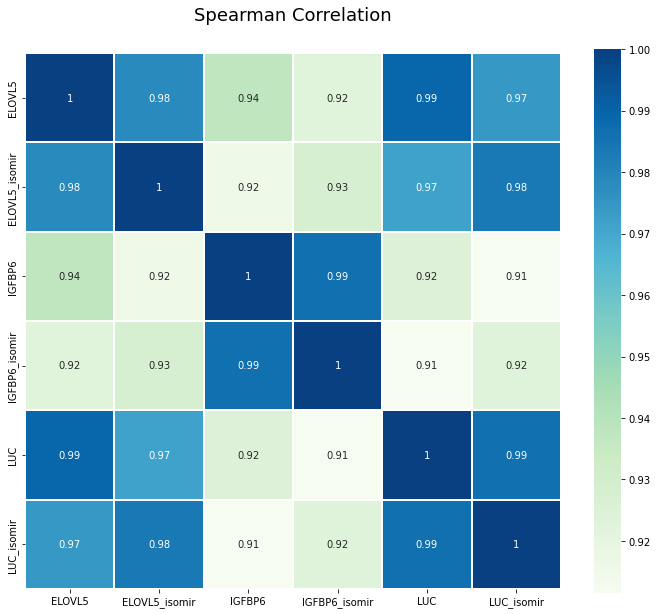

In [29]:
colormap = plt.cm.GnBu
plt.figure(figsize=(12,10))

plt.title('Spearman Correlation', y=1.05, size=18)
sns.heatmap(sps.spearmanr(mirDeep)[0],
            linewidths=0.1, vmax=1.0, 
            xticklabels = mirDeep.columns,
            yticklabels = mirDeep.columns,
            square=True, cmap=colormap, linecolor='white', annot=True)

In [31]:
sps.spearmanr(mirDeep)[0]

array([[1.        , 0.97829112, 0.93728964, 0.92283818, 0.98918807,
        0.97432279],
       [0.97829112, 1.        , 0.9159601 , 0.92770076, 0.97137272,
        0.98348031],
       [0.93728964, 0.9159601 , 1.        , 0.98623033, 0.92476264,
        0.91153854],
       [0.92283818, 0.92770076, 0.98623033, 1.        , 0.91163032,
        0.92329944],
       [0.98918807, 0.97137272, 0.92476264, 0.91163032, 1.        ,
        0.98621941],
       [0.97432279, 0.98348031, 0.91153854, 0.92329944, 0.98621941,
        1.        ]])

### IsomiR's expression (corr) 
* **Задача**: сравнить, схожи ли выдаваемые результаты секвенирования с уже определенными изоформами, с результатами Isomirmap

In [33]:
ELOV5 = get_table("ELOV5", "exclusive", 5)
IGFBP6 = get_table("IGFBP6", "exclusive", 5)
LUC = get_table("LUC", "exclusive", 5)

In [34]:
ELOV5

5,License Plate,IsomiR sequence,RPM ELOV5,Mature
1,iso-22-BRS28UEYP,AACCCGTAGATCCGAACTTGTG,26558.39,"[MIMAT0000098&hsa-miR-100-5p&offsets|0|0, m-27..."
2,iso-23-VIV6OYINDR,TAGCTTATCAGACTGATGTTGAC,16194.79,"[MIMAT0000076&hsa-miR-21-5p&offsets|0|+1, m-1&..."
3,iso-22-XKVL7YXYQ,TGAGGTAGTAGTTTGTGCTGTT,8314.01,"[MIMAT0000415&hsa-let-7i-5p&offsets|0|0, m-49&..."
4,iso-22-XKVLRYVPQ,TGAGGTAGTAGGTTGTATAGTT,5858.85,"[MIMAT0000062&hsa-let-7a-5p&offsets|0|0, m-6&1..."
5,iso-21-BRS28UEYE,AACCCGTAGATCCGAACTTGT,4748.83,"[MIMAT0000098&hsa-miR-100-5p&offsets|0|-1, m-2..."
...,...,...,...,...
8907,iso-21-ZY97KQ8RD,TTTTGTGTCTCCCATTCCCCC,0.13,[MIMAT0021044&hsa-miR-5010-3p&offsets|0|-2(+1C...
8908,iso-25-ZZJXZI3UKB,TTTTTCATTATTGCTCCTGACCAAA,0.13,"[MIMAT0004703&hsa-miR-335-3p&offsets|0|0(+3A),..."
8909,iso-23-ZZJXZI3UD3,TTTTTCATTATTGCTCCTGACCT,0.13,"[MIMAT0004703&hsa-miR-335-3p&offsets|0|+1, m-1..."
8910,iso-21-ZZJXZI3U0,TTTTTCATTATTGCTCCTGAG,0.13,[MIMAT0004703&hsa-miR-335-3p&offsets|0|-2(+1G)...
